# Plot Morality Index

In [1]:
from pathlib import Path
import os

path = os.getcwd()
parent = str(Path(path).parent.absolute())

print('Current path:', path)
print('Parent path:', parent)

Current path: /home/pw/projects/mfstocks/code_and_data/prep_and_cleaning
Parent path: /home/pw/projects/mfstocks/code_and_data


Read data

In [2]:
import pandas as pd

news = pd.read_csv(path + '/processed_data/emfd_processed.csv')

Get product of moral sentiment and foundation probabilities

In [3]:
# 1. Z-transform mf-probability and mf-sentiment scores
from scipy import stats

def standardize(df):
    probabilities = ['care_p', 'fairness_p', 'loyalty_p', 'authority_p','sanctity_p']
    sentiments = ['care_sent', 'fairness_sent', 'loyalty_sent','authority_sent','sanctity_sent']
    
    for p in probabilities:
        df[p] = stats.zscore(df[p])
    for s in sentiments:
        df[s] = stats.zscore(df[s])
        
    return df

In [4]:
# 2. Multiply transformed mf-probability * mf-sentiment
def multiply(df):
    foundations = ['care','fairness','loyalty','authority','sanctity']

    for f in foundations:
        df[f+'_prod'] = df[f+'_p'] * df[f+'_sent']
        
    return df

In [5]:
# 3. Get product and vice-virtue columns 

import numpy as np

def vice_virtue(df):
    foundations = ['care','fairness','loyalty','authority','sanctity']
    
    return df

In [6]:
standardized_news = standardize(news)
multiplied_news = multiply(standardized_news)
processed_news = vice_virtue(multiplied_news)

In [7]:
print(processed_news.shape)
processed_news.head(3)

(382185, 21)


,datetime2,url,source_x,title,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,care_sent,...,loyalty_sent,authority_sent,sanctity_sent,total_words,datetime2.1,care_prod,fairness_prod,loyalty_prod,authority_prod,sanctity_prod
0,2019-10-31 19:00:00-04:00,https://www.usatoday.com/story/sports/nfl/reds...,usatoday.com,"Trent Williams, Redskins OT, says he had cance...",-0.490637,-0.122111,-0.080776,-0.547307,-0.024252,0.638834,...,0.871099,0.388530,0.796268,665.0,2.019110e+13,-0.313436,-0.049930,-0.070363,-0.212645,-0.019311
1,2019-10-31 19:00:00-04:00,https://www.barrons.com/articles/pinterest-sto...,barrons.com,Pinterest Stock Plunges on Sales Miss,-0.241688,-0.238807,-1.138969,-1.681014,0.302931,-0.306184,...,1.105342,1.046928,0.030707,229.0,2.019110e+13,0.074001,-0.160204,-1.258951,-1.759901,0.009302
2,2019-10-31 19:00:00-04:00,https://www.washingtonpost.com/opinions/global...,washingtonpost.com,Baghdadi's death could mean more American with...,0.192691,-0.349759,0.442390,0.083854,0.127694,-0.143897,...,-0.118434,-0.264733,0.272698,730.0,2.019110e+13,-0.027728,0.018158,-0.052394,-0.022199,0.034822


Apply datetime index and aggregate to daily intervals

In [8]:
def datetime_index(df, colname_str):
    dt = pd.to_datetime(df[colname_str], format='%Y-%m-%d %H:%M:%S%z',utc=True)
    df.index = df.set_index(dt).tz_convert('US/Eastern').index
    return df

In [9]:
processed_news_dt = datetime_index(processed_news, "datetime2")
processed_news_daily = processed_news_dt.resample("D").mean()
processed_news_rolling = processed_news_daily.rolling(7).mean()

In [10]:
processed_news_daily.head(3)

,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,total_words,datetime2.1,care_prod,fairness_prod,loyalty_prod,authority_prod,sanctity_prod
datetime2,,,,,,,,,,,,,,,,,
2019-10-31 00:00:00-04:00,-0.166555,-0.073782,0.126808,0.179641,-0.033948,0.044590,0.054590,-0.142300,-0.030937,-0.184814,326.960854,2.019110e+13,-0.437136,-0.144970,-0.138572,-0.397815,-0.198149
2019-11-01 00:00:00-04:00,-0.104537,0.009142,0.023863,0.021268,-0.052746,0.049866,0.079945,-0.014565,0.023753,-0.019631,388.233753,2.019110e+13,-0.320217,-0.071180,-0.084984,-0.222994,-0.151387
2019-11-02 00:00:00-04:00,0.018152,-0.058712,0.037535,0.186527,0.091425,-0.105975,-0.027883,-0.144008,-0.099175,-0.153254,367.268493,2.019110e+13,-0.399588,-0.091736,-0.125424,-0.405016,-0.198671


Plot figures

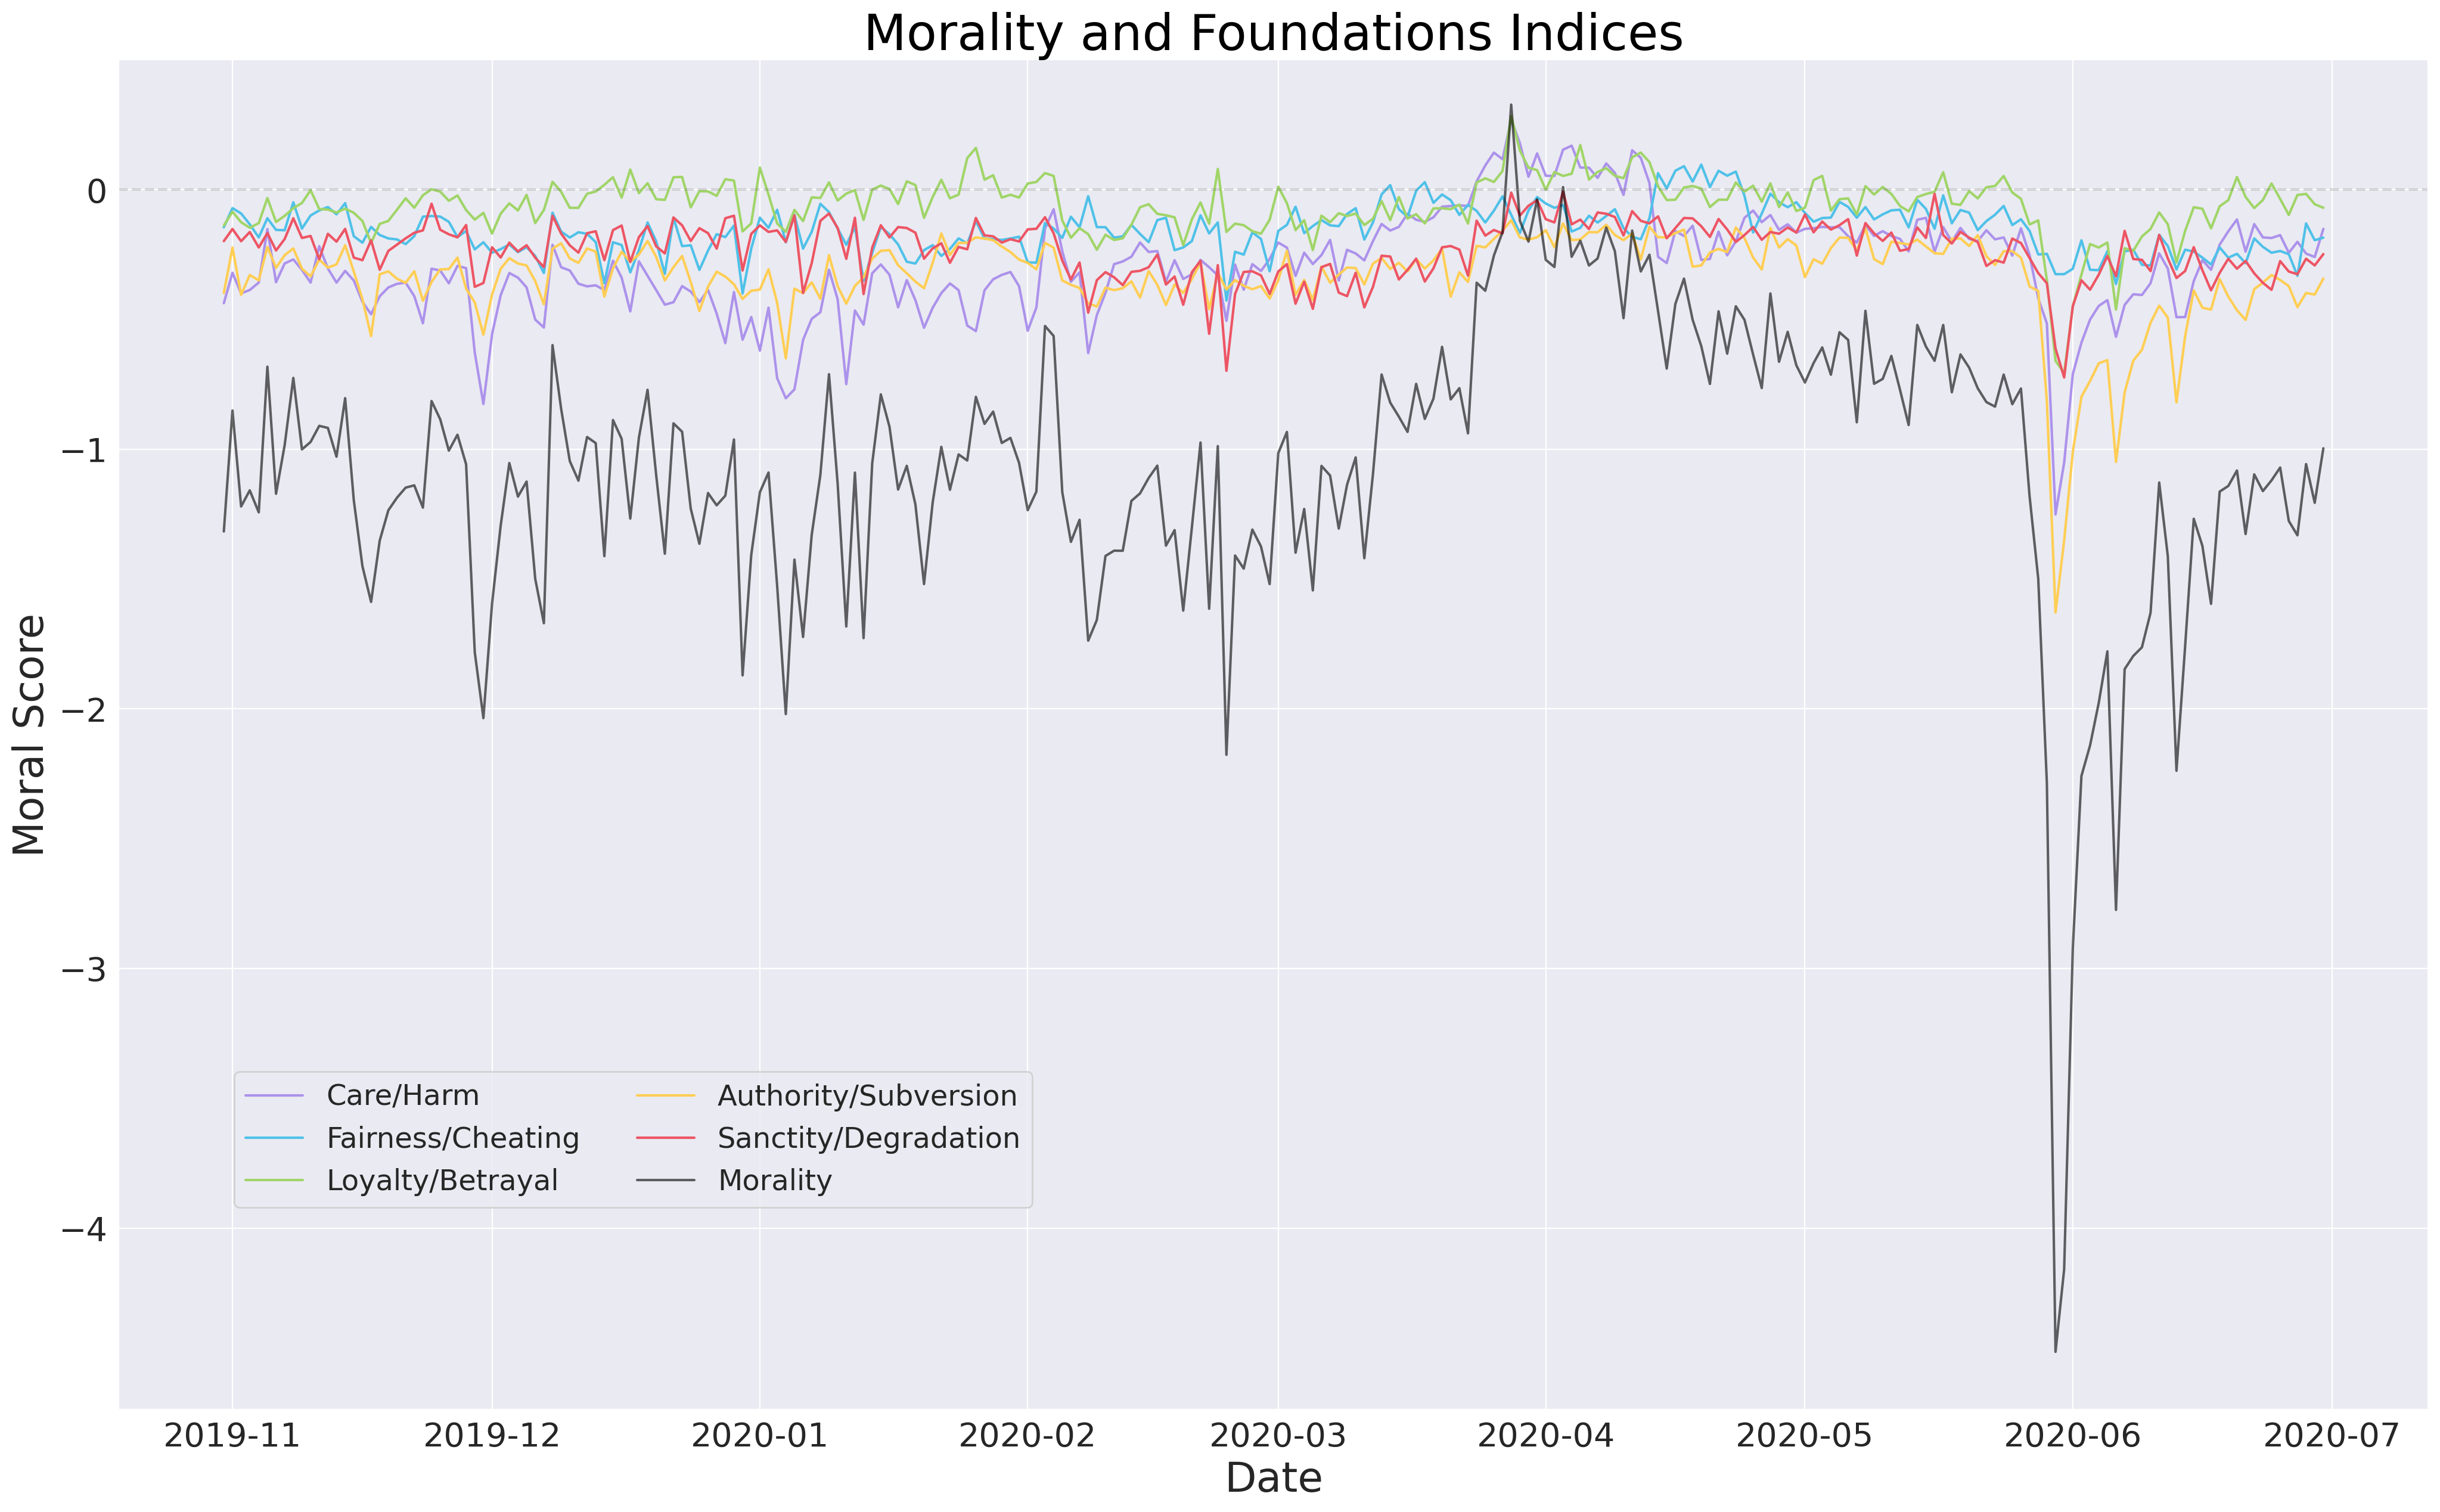

In [35]:
# define variables
x = processed_news_daily.index.tolist()

care = processed_news_daily.care_prod
fairness = processed_news_daily.fairness_prod
loyalty = processed_news_daily.loyalty_prod
authority = processed_news_daily.authority_prod
sanctity = processed_news_daily.sanctity_prod

morality = care + fairness + loyalty + authority + sanctity

# plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25,15), dpi=200)

plt.plot(x, care, '#ac92eb', label='Care/Harm', alpha=1)
plt.plot(x, fairness, '#4fc1e8', label='Fairness/Cheating', alpha=1)
plt.plot(x, loyalty, '#a0d568', label='Loyalty/Betrayal', alpha=1)
plt.plot(x, authority, '#ffce54', label='Authority/Subversion', alpha=1)
plt.plot(x, sanctity, '#ed5564', label='Sanctity/Degradation', alpha=1)
plt.plot(x, morality, 'black', label='Morality', alpha=0.6)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)

plt.legend(loc=(0.05, 0.15), fontsize='xx-large', ncol=2)
plt.title('Morality and Foundations Indices', fontdict={'color': 'black','size': 20}, fontsize=30)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Moral Score', fontsize=25)
plt.ylim(-4.7,0.5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
sns.set_style('darkgrid')

plt.savefig(path + '/figs/index_morality.png')

Read in stocks data. Resample to daily intervals.

In [12]:
spx = pd.read_csv(path + "/spx/SPX_2010_2020.csv",parse_dates=True).sort_index()

spx_dt = datetime_index(spx, "dt")

In [13]:
spx_daily = spx.resample("D").last().ffill()
spx_rolling = spx_daily.rolling(7).mean()

In [14]:
spx_rolling.head(10)

,high,open,low,close
dt,,,,
2019-11-01 00:00:00-04:00,NaN,NaN,NaN,NaN
2019-11-02 00:00:00-04:00,NaN,NaN,NaN,NaN
2019-11-03 00:00:00-04:00,NaN,NaN,NaN,NaN
2019-11-04 00:00:00-05:00,NaN,NaN,NaN,NaN
2019-11-05 00:00:00-05:00,NaN,NaN,NaN,NaN
2019-11-06 00:00:00-05:00,NaN,NaN,NaN,NaN
2019-11-07 00:00:00-05:00,3073.655714,3073.655714,3073.652857,3073.654286
2019-11-08 00:00:00-05:00,3077.394286,3077.394286,3077.391429,3077.392857
2019-11-09 00:00:00-05:00,3081.132857,3081.132857,3081.130000,3081.131429


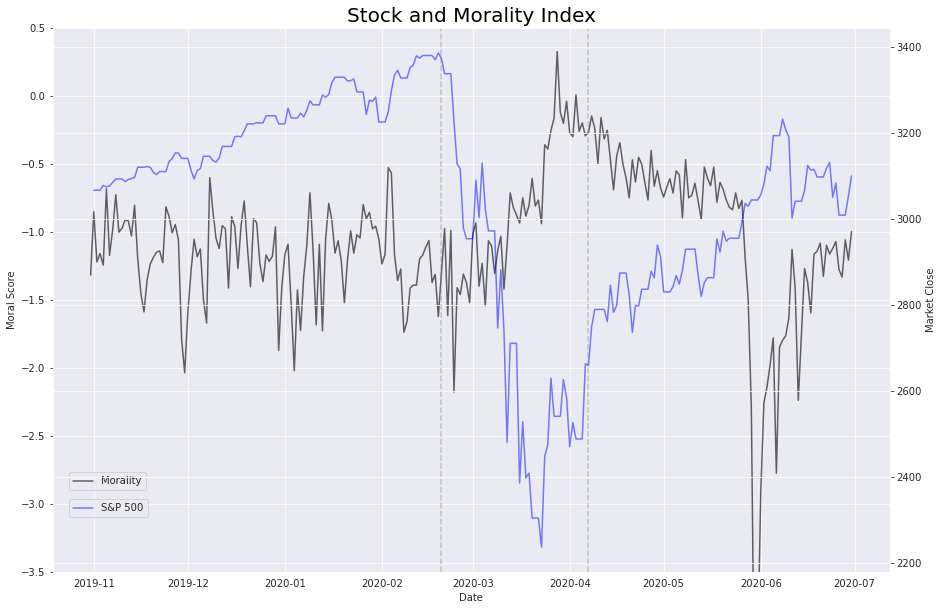

In [15]:
#define variables
x1 = processed_news_daily.index.tolist()
x2 = spx_daily.index.tolist()

care = processed_news_daily.care_prod
fairness = processed_news_daily.fairness_prod
loyalty = processed_news_daily.loyalty_prod
authority = processed_news_daily.authority_prod
sanctity = processed_news_daily.sanctity_prod

morality = care + fairness + loyalty + authority +  sanctity
sp500 = spx_daily.close

import matplotlib.pyplot as plt
import seaborn as sns

# specify ax1
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(x1, morality, 'black', label='Morality', alpha=0.6)
ax1.set_xlabel('Date')
ax1.set_ylabel('Moral Score')
ax1.tick_params(axis='y')
ax1.legend(loc=(0.02, 0.15), fontsize='medium')
ax1.set_ylim(-3.5,0.5)

# specify ax2
ax2 = ax1.twinx()

ax2.plot(x2, sp500, 'blue', label='S&P 500', alpha=0.5)
ax2.set_ylabel('Market Close')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
ax2.legend(loc=(0.02, 0.1), fontsize='medium')

plt.axvline(pd.Timestamp('2020-02-20'), color='grey', linestyle='--', alpha=0.4)
plt.axvline(pd.Timestamp('2020-04-07'), color='grey', linestyle='--', alpha=0.4)
plt.title('Stock and Morality Index', fontdict={'color': 'black', 'size': 20})
sns.set_style('darkgrid')


plt.savefig(path + '/figs/index_stocks_and_morality.png')

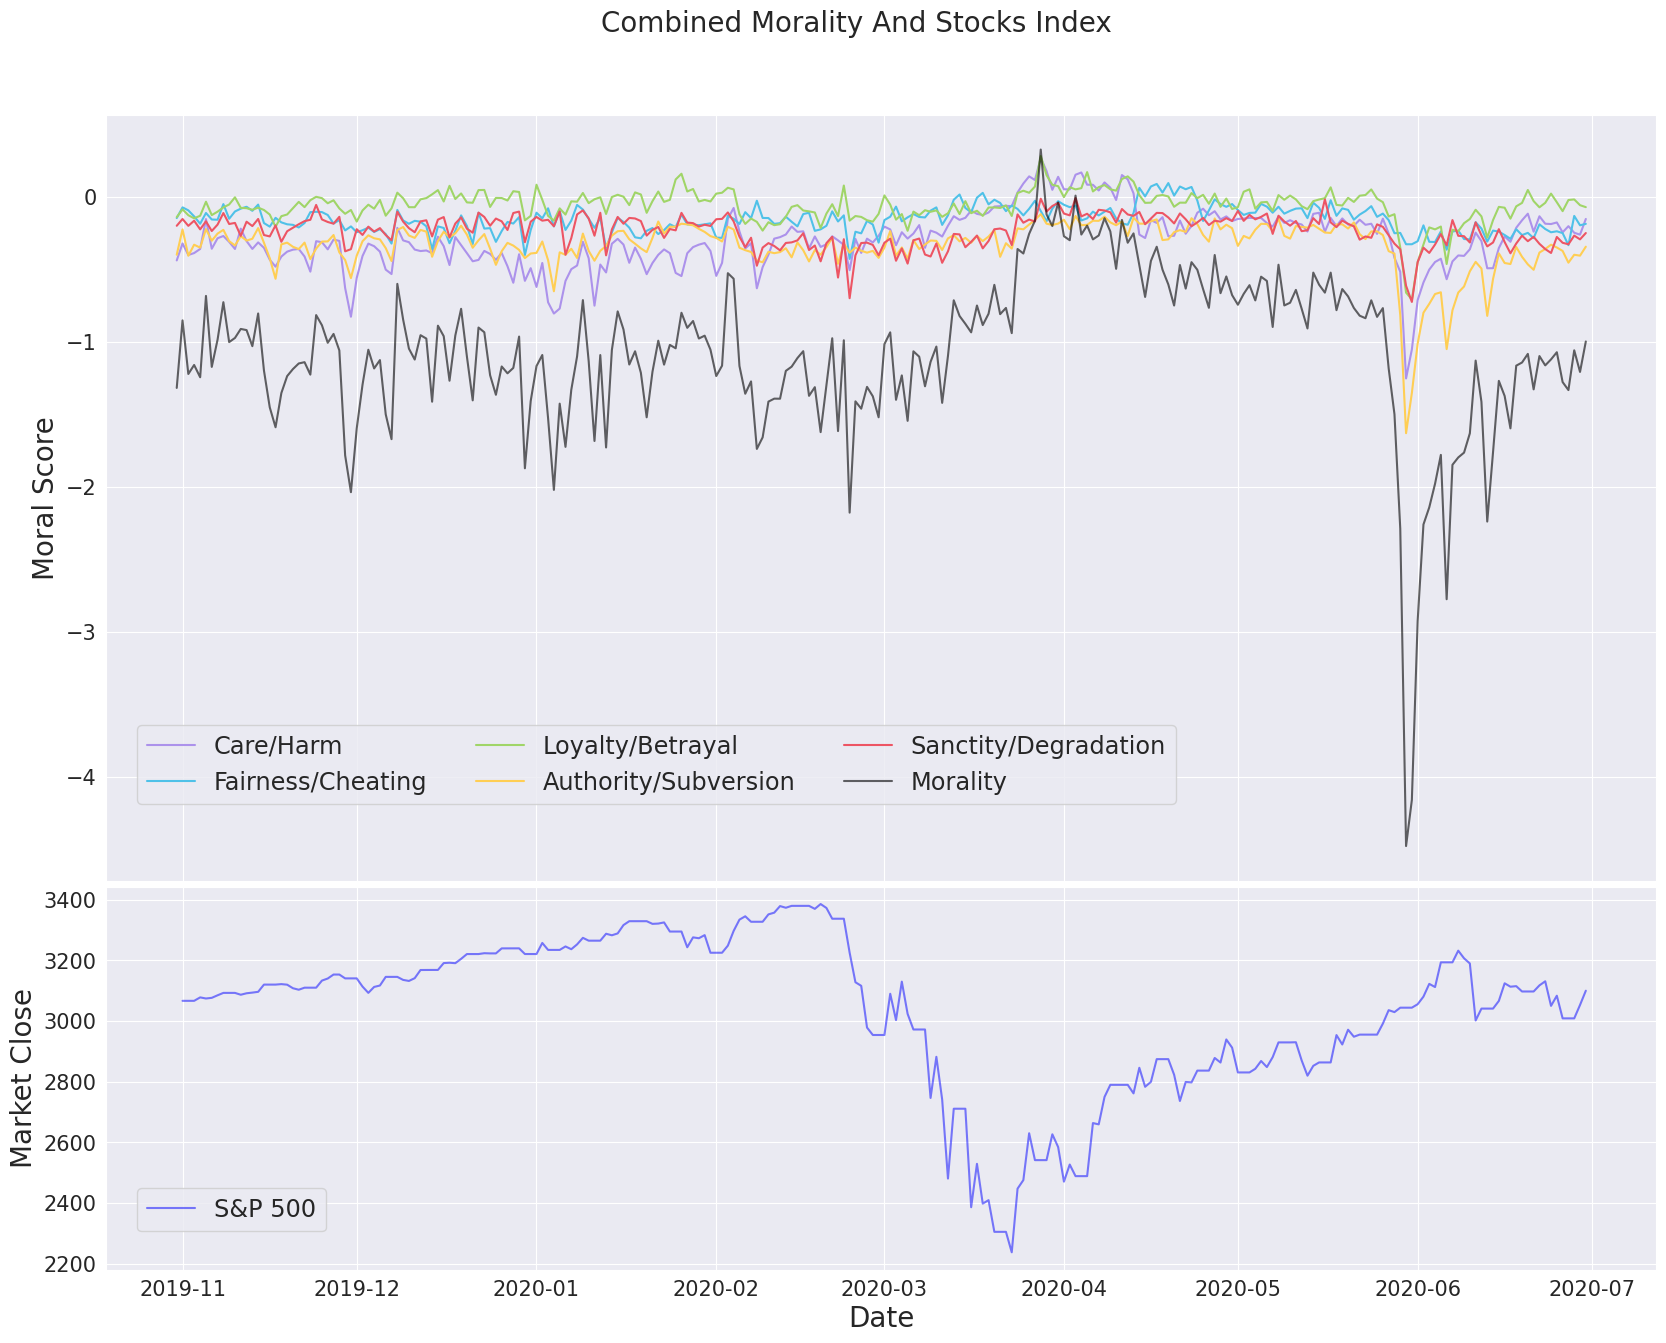

In [34]:
#define variables
x1 = processed_news_daily.index.tolist()
x2 = spx_daily.index.tolist()

care = processed_news_daily.care_prod
fairness = processed_news_daily.fairness_prod
loyalty = processed_news_daily.loyalty_prod
authority = processed_news_daily.authority_prod
sanctity = processed_news_daily.sanctity_prod
morality = care + fairness + loyalty + authority +  sanctity

sp500 = spx_daily.close

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=[20,15])
gs = fig.add_gridspec(2, hspace=0.01, height_ratios=[2, 1])
ax = gs.subplots(sharex=True)
fig.suptitle('Combined Morality And Stocks Index', y=0.95, fontsize=20)

# Hide x labels and tick labels for all but bottom plot.
for a in ax:
    a.label_outer()

# specify ax1
ax[0].plot(x1, care, '#ac92eb', label='Care/Harm', alpha=1)
ax[0].plot(x1, fairness, '#4fc1e8', label='Fairness/Cheating', alpha=1)
ax[0].plot(x1, loyalty, '#a0d568', label='Loyalty/Betrayal', alpha=1)
ax[0].plot(x1, authority, '#ffce54', label='Authority/Subversion', alpha=1)
ax[0].plot(x1, sanctity, '#ed5564', label='Sanctity/Degradation', alpha=1)
ax[0].plot(x1, morality, 'black', label='Morality', alpha=0.6)
ax[0].set_ylabel('Moral Score', fontsize=20)
ax[0].legend(loc=(0.02, 0.1), ncol=3, fontsize='xx-large')
ax[0].tick_params(axis='x', which='both',labelbottom=False)
ax[0].tick_params(axis='y',labelsize=15)


# specify ax2
ax[1].plot(x2, sp500, 'blue', label='S&P 500', alpha=0.5)
ax[1].set_xlabel('Date', fontsize=20)
ax[1].set_ylabel('Market Close', fontsize=20)  # we already handled the x-label with ax1
ax[1].tick_params(axis='x',labelsize=15)
ax[1].tick_params(axis='y',labelsize=15)

ax[1].legend(loc=(0.02, 0.1), fontsize='xx-large')

sns.set_style('darkgrid')
plt.show()
#plt.savefig(path + '/figs/index_combined.png')